In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
# # for unzipping the zip file run this
# !unzip '/content/drive/MyDrive/Deepfake/TRAIN.zip' -d "/content/drive/MyDrive/Deepfake/"

## Building a deepfake image detection model which is capable of classifying image into two categories Ai-Genrated or Real image using TensorFlow

# Problem Definition
* The model is used for detection of deepfake or Ai-generated images that
  are now widly used for spreading hate speech and fake news.

# Data
* We are using Kaggle data  uploaded on the drive and will also upload     zip file on github  <i>refer https://github.com/vrmaverick/DeepFake_Detector </i>

# Evaluation

* Prediction Probalities should be more than 90% which is this projects goal to acheive

# Features

* Few key information abot features as the project is based on image classification which are unstructured, Thus there is no such distinctive feature but the data is divide into 3 parts . Testing,Training and Validation. and the model will be a binary classifier

In [32]:
# Importing all required tools
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split

# For Data Structuring
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# File Handling
import os

# For image processing
from matplotlib.pyplot import imread

In [33]:
print("TF Version",tf.__version__)
print("TF hub version :",hub.__version__)

TF Version 2.15.0
TF hub version : 0.16.1


# Checking for GPU accessibility
Can change runtime type if needed on  google collab


In [34]:
print("GPU available"if tf.config.list_physical_devices("GPU")else "Not Available")

Not Available


# Defining all the Functions that are used in the notebook further

In [68]:
# Generating file paths for images
def paths(p):
  """
  Navigate through Drive paths to access files from a particular folder
  takes one args

  """
  # Specify the folder path within your Google Drive
  folder_path = p
  # List files in the folder
  file_paths = []
  file_name = []
  for root, dirs, files in os.walk(folder_path):
      for file in files:
          file_paths.append(os.path.join(root, file))
          file_name.append(file)
          # print(f"File Path: {os.path.join(root, file)}")
  return file_paths,file_name


IMG_SIZE = 224
# Image Preprocessing
def process_image(ImagePath,img_size= IMG_SIZE):
  """
  Take image file path and convert image into tensors

  """
  # Read the image file
  image = tf.io.read_file(ImagePath)

  #Turning .jpg or jpeg into tensors (R,G,B)
  image = tf.image.decode_jpeg(image,channels = 3) #(R,G,B)

  # Normalizing the image by converting range 0 - 255 to 0 - 1
  image = tf.image.convert_image_dtype(image,tf.float32)

  # Resize the image to (224,224)
  image = tf.image.resize(image,size=[img_size,img_size])

  return image


# Create a simple function to return a tuple (image, label)
def get_tupple(image_path, label):
  """
  Takes an image file path name and the assosciated label,
  processes the image and reutrns a typle of (image, label).
  """
  image = process_image(image_path)
  return image, label



BATCH_SIZE = 32
# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_tupple).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the iamge path into a preprocessed image)
    data = data.map(get_tupple)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch



def visualize_25_images(image,labels):
  """
  Displays 25 images from a batch with labels

  """
  plt.figure(figsize=(10,10))
  for i in range(25):
    ax= plt.subplot(5,5,i+1)# row,column,index
    plt.imshow(image[i])
    plt.title(unique[labels[i].argmax()])
    plt.axis(plt.axis("off"))


# Getting our data ready

*Turning our images to tensors or numerical format*

To check if image exists on that path run the cell below else one may skip it

In [36]:
!ls '/content/drive/MyDrive/Deepfake/TRAIN/FAKE'

000000004970.jpg  000000124197.jpg  000000239581.jpg  000000352233.jpg	000000465579.jpg
000000005032.jpg  000000124202.jpg  000000239613.jpg  000000352399.jpg	000000465676.jpg
000000005033.jpg  000000124210.jpg  000000239654.jpg  000000352444.jpg	000000465844.jpg
000000005046.jpg  000000124365.jpg  000000239697.jpg  000000352445.jpg	000000465854.jpg
000000005076.jpg  000000124390.jpg  000000239785.jpg  000000352533.jpg	000000465856.jpg
000000005115.jpg  000000124428.jpg  000000239837.jpg  000000352561.jpg	000000466005.jpg
000000005174.jpg  000000124615.jpg  000000239917.jpg  000000352654.jpg	000000466035.jpg
000000005215.jpg  000000124703.jpg  000000240082.jpg  000000352738.jpg	000000466037.jpg
000000005259.jpg  000000124880.jpg  000000240185.jpg  000000352949.jpg	000000466079.jpg
000000005303.jpg  000000124914.jpg  000000240196.jpg  000000353067.jpg	000000466093.jpg
000000005328.jpg  000000124995.jpg  000000240227.jpg  000000353300.jpg	000000466095.jpg
000000005385.jpg  000000125038.j

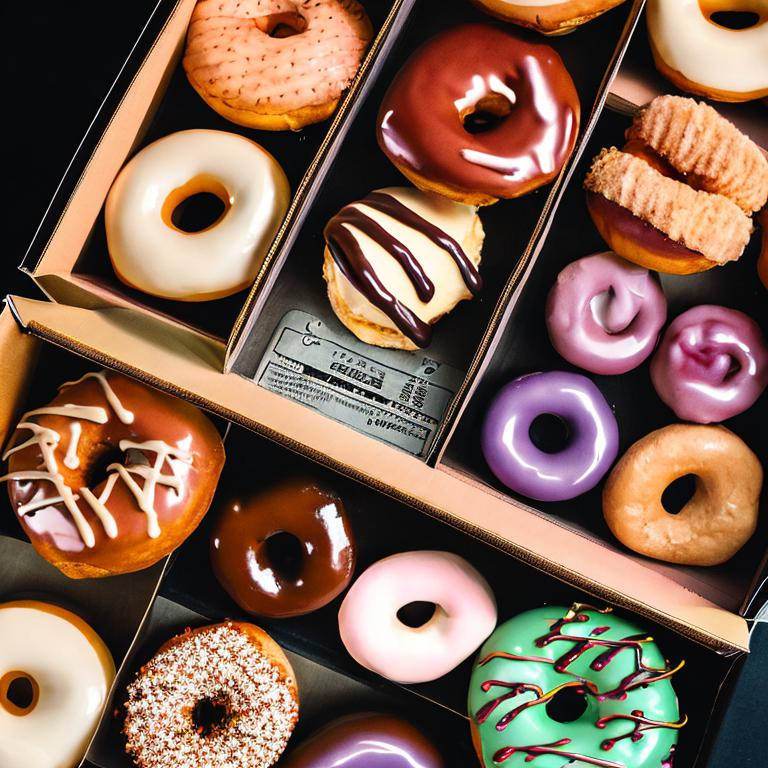

In [37]:
# Can be used for displaying images
from IPython.display import Image
Image('/content/drive/MyDrive/Deepfake/TRAIN/FAKE/000000580579.jpg')

# Getting image paths and labels

****************************************************************************

## *Skip Execution if already Done*......................................

In [38]:
# Accessing File paths of Ai Generated images which will be used for training
file_paths,file_name = paths('/content/drive/MyDrive/Deepfake/TRAIN/FAKE')

In [39]:
len(file_paths)

10000

In [40]:
len(file_name)

10000

In [41]:
# Creating a DataFrame for Convinience
df = pd.DataFrame(file_name, columns=['Image'])
df['Path']= file_paths
df['Class']='Fake'
df.head()

,Image,Path,Class
0,000000518785.jpg,/content/drive/MyDrive/Deepfake/TRAIN/FAKE/000...,Fake
1,000000521197.jpg,/content/drive/MyDrive/Deepfake/TRAIN/FAKE/000...,Fake
2,000000521288.jpg,/content/drive/MyDrive/Deepfake/TRAIN/FAKE/000...,Fake
3,000000520100.jpg,/content/drive/MyDrive/Deepfake/TRAIN/FAKE/000...,Fake
4,000000518933.jpg,/content/drive/MyDrive/Deepfake/TRAIN/FAKE/000...,Fake


In [42]:
# Accessing File paths of Real images which will be used for training
file_paths,file_name = paths('/content/drive/MyDrive/Deepfake/TRAIN/REAL')


In [43]:
print(len(file_name))
new_data = pd.DataFrame(file_name, columns=['Image'])
new_data['Path'] = file_paths
new_data['Class'] = 'Real'
resulting_data = pd.concat([df, new_data], ignore_index=True)
del new_data
resulting_data

10000


,Image,Path,Class
0,000000518785.jpg,/content/drive/MyDrive/Deepfake/TRAIN/FAKE/000...,Fake
1,000000521197.jpg,/content/drive/MyDrive/Deepfake/TRAIN/FAKE/000...,Fake
2,000000521288.jpg,/content/drive/MyDrive/Deepfake/TRAIN/FAKE/000...,Fake
3,000000520100.jpg,/content/drive/MyDrive/Deepfake/TRAIN/FAKE/000...,Fake
4,000000518933.jpg,/content/drive/MyDrive/Deepfake/TRAIN/FAKE/000...,Fake
...,...,...,...
19995,000000064307.jpg,/content/drive/MyDrive/Deepfake/TRAIN/REAL/000...,Real
19996,000000065601.jpg,/content/drive/MyDrive/Deepfake/TRAIN/REAL/000...,Real
19997,000000063681.jpg,/content/drive/MyDrive/Deepfake/TRAIN/REAL/000...,Real
19998,000000066156.jpg,/content/drive/MyDrive/Deepfake/TRAIN/REAL/000...,Real


In [44]:

resulting_data['Class'].value_counts()
resulting_data.to_csv('//content/drive/MyDrive/Deepfake/Test_Info.csv', index=False)

## Start Execution from below to save time no need to redo *****************

****************************************************************************

In [45]:
# resulting_data.to_csv('//content/drive/MyDrive/Deepfake/Test_Info.csv', index=False)
resulting_data = pd.read_csv('//content/drive/MyDrive/Deepfake/Test_Info.csv')
resulting_data

,Image,Path,Class
0,000000518785.jpg,/content/drive/MyDrive/Deepfake/TRAIN/FAKE/000...,Fake
1,000000521197.jpg,/content/drive/MyDrive/Deepfake/TRAIN/FAKE/000...,Fake
2,000000521288.jpg,/content/drive/MyDrive/Deepfake/TRAIN/FAKE/000...,Fake
3,000000520100.jpg,/content/drive/MyDrive/Deepfake/TRAIN/FAKE/000...,Fake
4,000000518933.jpg,/content/drive/MyDrive/Deepfake/TRAIN/FAKE/000...,Fake
...,...,...,...
19995,000000064307.jpg,/content/drive/MyDrive/Deepfake/TRAIN/REAL/000...,Real
19996,000000065601.jpg,/content/drive/MyDrive/Deepfake/TRAIN/REAL/000...,Real
19997,000000063681.jpg,/content/drive/MyDrive/Deepfake/TRAIN/REAL/000...,Real
19998,000000066156.jpg,/content/drive/MyDrive/Deepfake/TRAIN/REAL/000...,Real


In [46]:
# Shuffling data
resulting_data = resulting_data.sample(frac=1).reset_index(drop=True)

# Categorigal labels to tensors

In [47]:
labels = resulting_data['Class'].to_numpy()

In [48]:
labels

array(['Fake', 'Fake', 'Real', ..., 'Real', 'Real', 'Fake'], dtype=object)

In [49]:
# len(labels)
unique = np.unique(labels)
unique

array(['Fake', 'Real'], dtype=object)

Turning Labels into boolean or numeric form

In [50]:
bool_labels = [label == unique for label in labels]
bool_labels[:10]

[array([ True, False]),
 array([ True, False]),
 array([False,  True]),
 array([False,  True]),
 array([False,  True]),
 array([ True, False]),
 array([ True, False]),
 array([False,  True]),
 array([ True, False]),
 array([False,  True])]

In [51]:
len(bool_labels) #just for verification

20000

In [52]:
# Converting bool to Tensors
print("Binary Matrix = [fake,real]")
print(labels[11000])
print(bool_labels[11000].astype(int)) # as we have only two classes


Binary Matrix = [fake,real]
Real
[0 1]


# To reduce Time between Expirimentation we will take help of sampling 1000 images first to get good idea of the parameters

So we will start with 1000 images

In [53]:
# Number of images for expirimenting
NUM_IMAGES = 1000 #@param {type:"slider",min:100,max:47000}

# Modelling

Dividing the Dataset into 2 sets Training and Validation Datasets respectively

In [54]:
# df = pd.read_csv('//content/drive/MyDrive/Deepfake/Test_Info.csv')
# df

In [55]:
X = resulting_data['Path'].to_numpy()
print(X[:10],"Length :",len(X))

['/content/drive/MyDrive/Deepfake/TRAIN/FAKE/000000323336.jpg'
 '/content/drive/MyDrive/Deepfake/TRAIN/FAKE/000000510790.jpg'
 '/content/drive/MyDrive/Deepfake/TRAIN/REAL/000000012434.jpg'
 '/content/drive/MyDrive/Deepfake/TRAIN/REAL/000000329078.jpg'
 '/content/drive/MyDrive/Deepfake/TRAIN/REAL/000000387513.jpg'
 '/content/drive/MyDrive/Deepfake/TRAIN/FAKE/000000247909.jpg'
 '/content/drive/MyDrive/Deepfake/TRAIN/FAKE/000000291194.jpg'
 '/content/drive/MyDrive/Deepfake/TRAIN/REAL/000000090523.jpg'
 '/content/drive/MyDrive/Deepfake/TRAIN/FAKE/000000227598.jpg'
 '/content/drive/MyDrive/Deepfake/TRAIN/REAL/000000025388.jpg'] Length : 20000


In [56]:
Y = bool_labels
print(Y[:10],"Length :",len(Y))

[array([ True, False]), array([ True, False]), array([False,  True]), array([False,  True]), array([False,  True]), array([ True, False]), array([ True, False]), array([False,  True]), array([ True, False]), array([False,  True])] Length : 20000


In [57]:
X_train,X_val,Y_train,Y_val = train_test_split(X[:NUM_IMAGES],Y[:NUM_IMAGES],test_size=0.2,random_state=8) # Good For Expirimenting Faster Results
print(f'Xtrain length ={len(X_train)} ,Ytrain length ={len(Y_train)} ,Xval length ={len(X_val)} ,Yval length ={len(Y_val)}')

Xtrain length =800 ,Ytrain length =800 ,Xval length =200 ,Yval length =200


## Preprocessing images : Turning Images to tensors

Preprocess our images into tensors we are going to write a function so it can be reused

1. Take a image filepath as inputs
2. Use tensorflow to read file and save it to variable `image`
3. Turn `image` into tensors (jpg)
4. Normalize image pixels representation between 0 and 1
5. Resize the image to shape (224,224)
6. Return the modified image




***************************************************************************


 Optional : before lets see how to conver images in numpy arrays and image analysis

In [58]:
image = imread(X[4]) # Converts img to nupy array
print(image.shape) # Aspect ratio with colur lane
print(f'Minimum and Maximum value of a pixel ({image.max()},{image.min()})')

(768, 768, 3)
Minimum and Maximum value of a pixel (255,0)


In [59]:
# Converting array to tensor for faster computation
tf.constant(image)[:1]

<tf.Tensor: shape=(1, 768, 3), dtype=uint8, numpy=
array([[[ 49,  52,  61],
        [ 48,  51,  60],
        [ 49,  51,  63],
        ...,
        [134, 152, 162],
        [132, 150, 160],
        [132, 150, 160]]], dtype=uint8)>

***************************************************************************

# Lets Combine Tensors to Batches for faster processing

Using batch size is 32  as Yann LeCun stated
https://twitter.com/ylecun/status/989610208497360896


Why to turn data into batches??
Because if we are processing 10,000 images then they might not fall into 8 GB Ram or memory

In order if we want to use Tensorflow effectively we will require

We need Tensor Tupples `(image,labels)`

In [60]:
IMG_SIZE = 224 # image size (224,224) is recomended


In [61]:
get_tupple(X[10],Y[10])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[5.7507002e-01, 6.3305318e-01, 5.6022406e-01],
         [5.5374151e-01, 6.0274112e-01, 5.8459383e-01],
         [5.4553825e-01, 5.9371752e-01, 5.7236898e-01],
         ...,
         [6.9553804e-01, 7.4645847e-01, 8.0702251e-01],
         [5.6470507e-01, 6.0308039e-01, 6.4313620e-01],
         [5.9719872e-01, 6.3165247e-01, 6.5706271e-01]],
 
        [[5.9615844e-01, 6.5444177e-01, 5.7881159e-01],
         [5.4191679e-01, 5.9429777e-01, 5.5088037e-01],
         [5.7859147e-01, 6.3639456e-01, 5.5730295e-01],
         ...,
         [4.7987133e-01, 4.9331671e-01, 4.7791052e-01],
         [3.6022413e-01, 3.7226894e-01, 3.5406166e-01],
         [3.9035606e-01, 3.9657858e-01, 3.7947172e-01]],
 
        [[5.2070832e-01, 5.9443778e-01, 5.2154863e-01],
         [4.7779113e-01, 5.4865950e-01, 4.9235696e-01],
         [6.0220093e-01, 6.8091244e-01, 5.8063233e-01],
         ...,
         [4.2753136e-01, 4.1234529e-01, 4.0956417e-01],


In [62]:
train_data = create_data_batches(X_train,y=Y_train)
Val_data = create_data_batches(X_val,y=Y_val,valid_data = True)

Creating training data batches...
Creating validation data batches...


In [63]:
print(f'train data batch {train_data.element_spec} and val data batch {Val_data}')

train data batch (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.bool, name=None)) and val data batch <_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.bool, name=None))>


# Visualizing our batches

Our data is now in batches however it can be hard to understand or comprehend lets visualize the batches

In [64]:
# making train data into iterator so we can visualize
train_images, train_labels = next(train_data.as_numpy_iterator())# creating or generating the bathes
print(len(train_images),len(train_labels)) #32 is the batch size

32 32


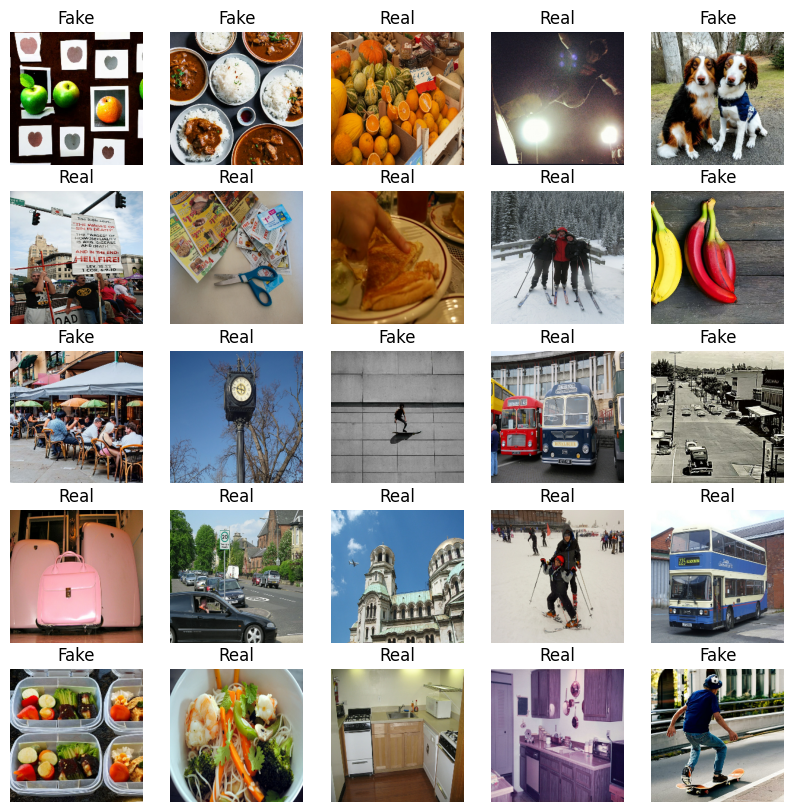

In [65]:
# visualizing
visualize_25_images(train_images, train_labels)

# Preparing the inputs and outputs of the model
  **We need to define a few things**
  * The `input` shape
  * The `output`shape
  * The URL of model we Want to use



In [66]:
# Building our deep-learning model using Transfer Learning rather thhan building from scratch for baseline results
# Before we proceed

INPUT_SHAPE = [None,IMG_SIZE,IMG_SIZE,3]
OUTPUT_SIZE = len(unique)
url = "https://kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/130-224-classification/versions/1"


We will be using Tensorflow Keras deep learning model

Keras is the high-level API of the TensorFlow platform. It provides an approachable, highly-productive interface for solving machine learning (ML) problems, with a focus on modern deep learning. Keras covers every step of the machine learning workflow, from data processing to hyperparameter tuning to deployment. It was developed with a focus on enabling fast experimentation.

We have already defined a function
1. It takes ithe input and output shapes as a parameter
2. Define layers sequntially step by step
3. Compiles the model (Evaluate and improve)
4. Builds the model (Input shapes will be given)
5. Return Output

*Refer the documentation* https://www.tensorflow.org/guide/keras

In [70]:
def create_model(in_shape=INPUT_SHAPE,out_shape=OUTPUT_SIZE,mod_url=url):
  print("Building Model this may take time ............")
  print(f'Model url : {mod_url}')

  #setup model layers
  model = tf.keras.Sequential([
      hub.KerasLayer(mod_url),# Layer 1(input layer)
      tf.keras.layers.Dense(units=out_shape,
                            activation="softmax")#layer 2 (output layer)
  ])

  #Compile the model
  model.compile(
      loss = tf.keras.losses.CategoricalFocalCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics = ["accuracy"]
  )

  # Build the model
  model.build(in_shape)

  return model



In [71]:
model = create_model()
model.summary()

Building Model this may take time ............
Model url : https://kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/130-224-classification/versions/1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 2)                 2004      
                                                                 
Total params: 5434717 (20.73 MB)
Trainable params: 2004 (7.83 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________
